In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
import os

# CSV 파일 경로
base_path = r"C:\Users\bok7z\DACSV"

# CSV 파일 읽기
patients = pd.read_csv("./data/patients.csv")
admissions = pd.read_csv("./data/admissions.csv")
procedures = pd.read_csv("./data/procedures_icd.csv")
d_icd_procedures = pd.read_csv("./data/d_icd_procedures.csv")


# 정맥 카테터 삽입 수술 건 추출 전처리

In [2]:
# 1. 환자와 입원 데이터 조인
patients_subset = patients[["subject_id", "gender", "anchor_age"]]
admissions_subset = admissions[[
    "subject_id", "hadm_id", "admission_type", "insurance", "admittime", "dischtime"
]]
patient_admission = pd.merge(admissions_subset, patients_subset, on="subject_id", how="inner")

# 2. 수술 데이터 조인
procedures_subset = procedures[["hadm_id", "icd_code", "seq_num"]]
surgery_data = pd.merge(patient_admission, procedures_subset, on="hadm_id", how="left")

# 3. 수술 코드 설명 매핑
icd_mapping = d_icd_procedures[["icd_code", "long_title"]]
surgery_with_description = pd.merge(surgery_data, icd_mapping, on="icd_code", how="left")

# 4. 특정 수술 필터링
enteral_infusion_data = surgery_with_description[
    surgery_with_description["long_title"] == "Venous catheterization, not elsewhere classified"
]

# 날짜 데이터 처리
enteral_infusion_data['admittime'] = pd.to_datetime(enteral_infusion_data['admittime'])
enteral_infusion_data['dischtime'] = pd.to_datetime(enteral_infusion_data['dischtime'])

# 재입원 여부 계산
enteral_infusion_data['time_to_next_admission'] = enteral_infusion_data.groupby('subject_id')['admittime'].shift(-1) - enteral_infusion_data['dischtime']
enteral_infusion_data['time_to_next_admission'] = enteral_infusion_data['time_to_next_admission'].fillna(pd.Timedelta(days=0))
enteral_infusion_data['readmission_within_30_days'] = enteral_infusion_data['time_to_next_admission'].apply(
    lambda x: 1 if pd.notnull(x) and x <= pd.Timedelta(days=30) else 0
)

# 범주형 데이터 변환
enteral_infusion_data['long_title'] = enteral_infusion_data['long_title'].astype('category').cat.codes
enteral_infusion_data['admission_type'] = enteral_infusion_data['admission_type'].astype('category').cat.codes
enteral_infusion_data['insurance'] = enteral_infusion_data['insurance'].astype('category').cat.codes
enteral_infusion_data['gender'] = enteral_infusion_data['gender'].astype('category').cat.codes
enteral_infusion_data['icd_code'] = enteral_infusion_data['icd_code'].astype('category').cat.codes

/var/folders/db/vpd2vbln62d_v_cvwyfcw3z00000gn/T/ipykernel_15300/505399355.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enteral_infusion_data['admittime'] = pd.to_datetime(enteral_infusion_data['admittime'])
/var/folders/db/vpd2vbln62d_v_cvwyfcw3z00000gn/T/ipykernel_15300/505399355.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enteral_infusion_data['dischtime'] = pd.to_datetime(enteral_infusion_data['dischtime'])
/var/folders/db/vpd2vbln62d_v_cvwyfcw3z00000gn/T/ipykernel_15300/505399355.py:26

In [10]:
enteral_infusion_data.to_csv("./data/enteral_infusion_data.csv", index=False)

# NaN 처리
enteral_infusion_data = enteral_infusion_data.fillna(0)

# 데이터 전처리
##### icd_version이 9와 10인 icd_code들을 병합
##### icd_code_9와 icd_code_10을 감염성 질환, 신장계, 순환계, 혈액암/림프종, 호흡기, 혈액응고, 자가면역으로 세분화해서 변수를 생성하였으므로
##### icd_code_9와 icd_code_10은 삭제
##### 감염성 질환, 신장계, 순환계, 혈액암/림프종, 호흡기, 혈액응고, 자가면역에 해당하는 사람은 해당 변수를 1, 아닌 사람은 0으로 초기화

In [12]:
# diagnoses_icd.csv의 icd_version이 9, 10인 icd_code들을 enteral_infusion_data.csv에 join

# 데이터 불러오기
enteral_infusion_data = pd.read_csv('./data/enteral_infusion_data')
diagnoses_icd = pd.read_csv('./data/diagnoses_icd.csv')


# 질병 데이터 추출 전처리

In [14]:
# icd_version이 9인 데이터만 추출
diagnoses_icd_9 = diagnoses_icd[diagnoses_icd['icd_version'] == 9][['subject_id', 'icd_code']]
diagnoses_icd_9 = diagnoses_icd_9.rename(columns={'icd_code': 'icd_code_9'})

# icd_version이 10인 데이터만 추출
diagnoses_icd_10 = diagnoses_icd[diagnoses_icd['icd_version'] == 10][['subject_id', 'icd_code']]
diagnoses_icd_10 = diagnoses_icd_10.rename(columns={'icd_code': 'icd_code_10'})

# enteral_infusion_data와 icd_version 9 데이터를 subject_id 기준으로 조인
enteral_infusion_data_9 = pd.merge(enteral_infusion_data, diagnoses_icd_9, on='subject_id', how='left')

# enteral_infusion_data와 icd_version 10 데이터를 subject_id 기준으로 조인
enteral_infusion_data_10 = pd.merge(enteral_infusion_data_9, diagnoses_icd_10, on='subject_id', how='left')

# 결과 확인
print(enteral_infusion_data_10.head())

   subject_id   hadm_id  admission_type  insurance            admittime  \
0    11785054  26269995               3          2  2115-02-08 17:52:00   
1    11785054  26269995               3          2  2115-02-08 17:52:00   
2    11785054  26269995               3          2  2115-02-08 17:52:00   
3    11785054  26269995               3          2  2115-02-08 17:52:00   
4    11785054  26269995               3          2  2115-02-08 17:52:00   

             dischtime  gender  anchor_age  icd_code  seq_num  long_title  \
0  2115-03-24 11:30:00       1           0         0      2.0           0   
1  2115-03-24 11:30:00       1           0         0      2.0           0   
2  2115-03-24 11:30:00       1           0         0      2.0           0   
3  2115-03-24 11:30:00       1           0         0      2.0           0   
4  2115-03-24 11:30:00       1           0         0      2.0           0   

  time_to_next_admission  readmission_within_30_days icd_code_9 icd_code_10  
0       

In [27]:
# subject_id의 누락 없이 성공적으로 잘 join이 된 것을 확인

print("병합 전 enteral_infusion_data의 subject_id 개수:", enteral_infusion_data['subject_id'].nunique())
print("병합 후 enteral_infusion_data_10의 subject_id 개수:", enteral_infusion_data_10['subject_id'].nunique())


병합 전 enteral_infusion_data의 subject_id 개수: 10840
병합 후 enteral_infusion_data_10의 subject_id 개수: 10840


In [28]:
# 질병 카테고리와 ICD 코드 범위 정의
disease_categories = {
    "infectious_disease": {  # 감염성 질환
        "icd_9": range(1, 40),  # 001~039
        "icd_10": ["A" + str(i).zfill(2) for i in range(0, 100)],  # A00~B99
    },
    "renal_system": {  # 신장계
        "icd_9": range(590, 594),  # 590~593
        "icd_10": ["N" + str(i).zfill(2) for i in range(25, 30)],  # N25~N29
    },
    "circulatory_system": {  # 순환계
        "icd_9": range(390, 460),  # 390~459
        "icd_10": ["I" + str(i).zfill(2) for i in range(0, 100)],  # I00~I99
    },
    "hematologic_lymphatic": {  # 혈액암/림프종
        "icd_9": range(200, 209),  # 200~208
        "icd_10": ["C" + str(i).zfill(2) for i in range(81, 96)],  # C81~C95
    },
    "respiratory_system": {  # 호흡기
        "icd_9": range(460, 520),  # 460~519
        "icd_10": ["J" + str(i).zfill(2) for i in range(0, 100)],  # J00~J99
    },
    "coagulation": {  # 혈액응고
        "icd_9": [286],  # 286
        "icd_10": ["D" + str(i).zfill(2) for i in range(65, 70)],  # D65~D69
    },
    "immune_system": {  # 자가면역
        "icd_9": [279],  # 279
        "icd_10": ["D" + str(i).zfill(2) for i in range(80, 90)],  # D80~D89
    }
}

In [29]:

# 질병 카테고리에 대한 새로운 변수 생성
for category, codes in disease_categories.items():
    # ICD-9 처리
    condition_9 = enteral_infusion_data_10['icd_code_9'].apply(
        lambda x: 1 if pd.notnull(x) and x.isdigit() and int(x) in codes["icd_9"] else 0
    )
    # ICD-10 처리
    condition_10 = enteral_infusion_data_10['icd_code_10'].apply(
        lambda x: 1 if pd.notnull(x) and any(x.startswith(code[:1]) and code[1:] in x for code in codes["icd_10"]) else 0
    )
    # 두 조건 합쳐서 최종 변수 생성
    enteral_infusion_data_10[category] = condition_9 | condition_10

# 결과 확인
print(enteral_infusion_data_10.head())

   subject_id   hadm_id  admission_type  insurance            admittime  \
0    11785054  26269995               3          2  2115-02-08 17:52:00   
1    11785054  26269995               3          2  2115-02-08 17:52:00   
2    11785054  26269995               3          2  2115-02-08 17:52:00   
3    11785054  26269995               3          2  2115-02-08 17:52:00   
4    11785054  26269995               3          2  2115-02-08 17:52:00   

             dischtime  gender  anchor_age  icd_code  seq_num  ...  \
0  2115-03-24 11:30:00       1           0         0      2.0  ...   
1  2115-03-24 11:30:00       1           0         0      2.0  ...   
2  2115-03-24 11:30:00       1           0         0      2.0  ...   
3  2115-03-24 11:30:00       1           0         0      2.0  ...   
4  2115-03-24 11:30:00       1           0         0      2.0  ...   

   readmission_within_30_days icd_code_9  icd_code_10 infectious_disease  \
0                           1       V290          Na

In [30]:

# 결과를 CSV 파일로 저장
enteral_infusion_data_10.to_csv('enteral_infusion_data_with_disease_flags_final.csv', index=False)

In [31]:
enteral_infusion_data_10

,subject_id,hadm_id,admission_type,insurance,admittime,dischtime,gender,anchor_age,icd_code,seq_num,...,readmission_within_30_days,icd_code_9,icd_code_10,infectious_disease,renal_system,circulatory_system,hematologic_lymphatic,respiratory_system,coagulation,immune_system
0,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,...,1,V290,NaN,0,0,0,0,0,0,0
1,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,...,1,77989,NaN,0,0,0,0,0,0,0
2,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,...,1,V053,NaN,0,0,0,0,0,0,0
3,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,...,1,36224,NaN,0,0,0,0,0,0,0
4,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,...,1,28749,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70634347,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,...,1,4532,NaN,0,0,0,0,0,0,0
70634348,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,...,1,43820,NaN,0,0,0,0,0,0,0
70634349,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,...,1,27542,NaN,0,0,0,0,0,0,0
70634350,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,...,1,24900,NaN,0,0,0,0,0,0,0


In [32]:
# icd_code_9와 icd_code_10 변수 제거
enteral_infusion_data_10 = enteral_infusion_data_10.drop(columns=['icd_code_9', 'icd_code_10'])
# 결과 확인
print(enteral_infusion_data_10.head())


   subject_id   hadm_id  admission_type  insurance            admittime  \
0    11785054  26269995               3          2  2115-02-08 17:52:00   
1    11785054  26269995               3          2  2115-02-08 17:52:00   
2    11785054  26269995               3          2  2115-02-08 17:52:00   
3    11785054  26269995               3          2  2115-02-08 17:52:00   
4    11785054  26269995               3          2  2115-02-08 17:52:00   

             dischtime  gender  anchor_age  icd_code  seq_num  long_title  \
0  2115-03-24 11:30:00       1           0         0      2.0           0   
1  2115-03-24 11:30:00       1           0         0      2.0           0   
2  2115-03-24 11:30:00       1           0         0      2.0           0   
3  2115-03-24 11:30:00       1           0         0      2.0           0   
4  2115-03-24 11:30:00       1           0         0      2.0           0   

  time_to_next_admission  readmission_within_30_days  infectious_disease  \
0        0

In [33]:
enteral_infusion_data_10.to_csv('enteral_infusion_data_without_icd_codes.csv', index=False)

# 원핫인코딩 된 질병 변수 중복 샘플 결합

In [ ]:
b = enteral_infusion_data_10.drop_duplicates(keep='first')
b_grouped = b.groupby("hadm_id").max().reset_index()
b_grouped.to_csv("./data/enteral_data_final.csv", index = False)

[정확도]
장점: 단순하고 직관적, 클래스 불균형이 없을 때 유용
<br>단점: 클래스가 불균형할 경우 정확도가 높은 것처럼 보일 수 있음

[ROC-AUC]
정의: 클래스 별로 ROC 커브를 그려 각 클래스에 대해 True Positive Rate와 False Positive Rate 간의 관계 측정
<br>장점: 클래스 불균형에 상대적으로 덜 민감함. 클래스 간의 구분 능력 평가에 적합
<br>단점: 실질적인 분류 성능보다는 모델의 예측 점수의 분포 평가

[F1 Score]
정의: precision과 recall의 조화 평균
<br>장점: 클래스 간 불균형에 민감, False Negative와 False Positive를 동시에 고려
<br>단점: 특정 클래스에서 precision 또는 recall 중 하나가 너무 낮으면 점수가 급격히 낮아짐

In [ ]:
!pip install imbalanced-learn


# <질병변수 사용>
X는 질병 변수
<br>Y는 'readmission_within_30_days'

## XGBoost


### <li>SMOTE 적용 전 -> SMOTE 적용 후
모델 정확도: 0.9288 -> 0.7533
<br> ROC-AUC: 0.6491 -> 0.6418
<br>F1 Score: 0.9631 -> 0.8541
    
### <li>SMOTE 말고 scale_pos_weight 적용 후
모델 정확도: 0.9288
<br>ROC-AUC: 0.6458
<br>F1 Score: 0.9631

### <li>SMOTE 와 scale_pos_weight 모두 적용 후
모델 정확도: 0.8869
<br>ROC-AUC: 0.6418
<br>F1 Score: 0.9396


데이터 v1, XGBoost 모델 정확도: 0.7533
ROC-AUC: 0.6418
F1 Score: 0.8541


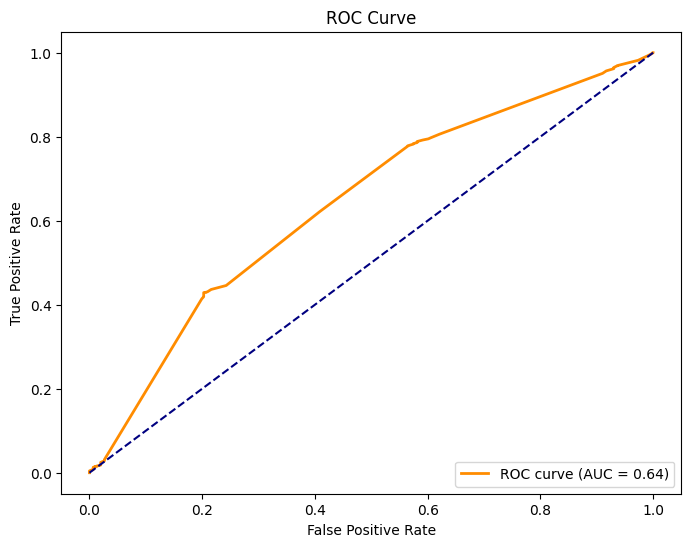

In [3]:
# SMOTE

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v1, XGBoost 모델 정확도: 0.9288
ROC-AUC: 0.6458
F1 Score: 0.9631


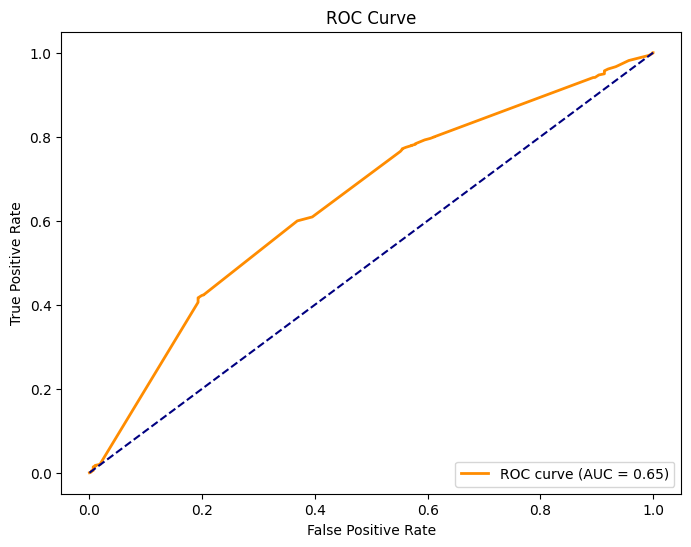

In [26]:
# with scale_pos_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 학습 with scale_pos_weight
scale_pos_weight = len(y_train) / sum(y_train)  # Negative to positive class ratio
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v1, XGBoost 모델 정확도: 0.8869
ROC-AUC: 0.6418
F1 Score: 0.9396


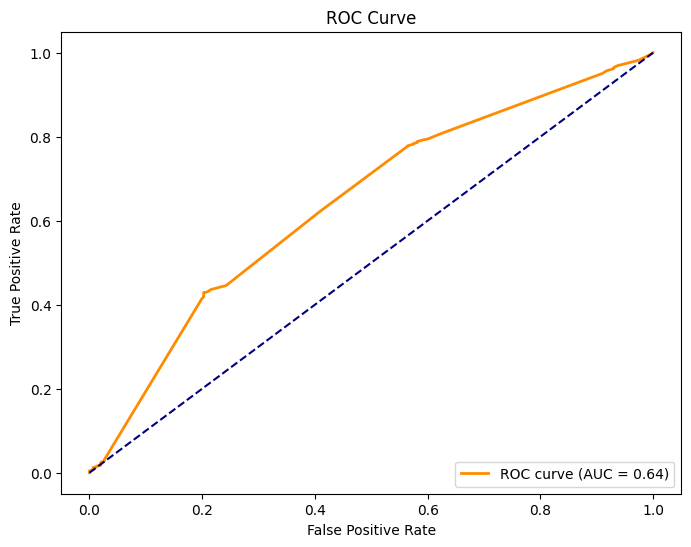

In [28]:
# SMOTE + class_weigth

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scale_pos_weight 설정
scale_pos_weight = len(y_train_resampled) / sum(y_train_resampled)  # Negative to positive class ratio

# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_resampled, y_train_resampled)

# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 

## 로지스틱 회귀(logistic Regression)를 활용
##### Regression Equation: y = 1.2216 + (-0.0688) * infectious_disease + (-0.0379) * renal_system + (0.0491) * circulatory_system + (0.8322) * hematologic_lymphatic + (0.0966) * respiratory_system + (0.2326) * coagulation + (0.1528) * immune_system
##### R^2 (Determination Coefficient): 0.0158->-2.4928
##### R^2이 상당히 낮은 것을 확인. 우리 데이터에는 적절하지 않은 분석 방식

### <li> SMOTE 적용 전 -> SMOTE 적용 후
모델 정확도: 0.9288 -> 0.7282
<br>ROC-AUC: 0.6492 -> 0.6516
<br>F1 Score: 0.9631 -> 0.8362

### <li> SMOTE 말고 class_weight='balanced' 사용
모델 정확도: 0.7272
<br>ROC-AUC: 0.6494
<br>F1 Score: 0.8355
    
### <li> SMOTE 와 class_weight 모두 적용 후
모델 정확도: 0.7282
<br>ROC-AUC: 0.6516
<br>F1 Score: 0.8362


Regression Equation: y = 0.7515 + (0.0115) * infectious_disease + (-0.3623) * renal_system + (-0.6746) * circulatory_system + (0.4914) * hematologic_lymphatic + (-0.7265) * respiratory_system + (-0.1655) * coagulation + (0.1408) * immune_system
R^2 (Determination Coefficient): -2.4928


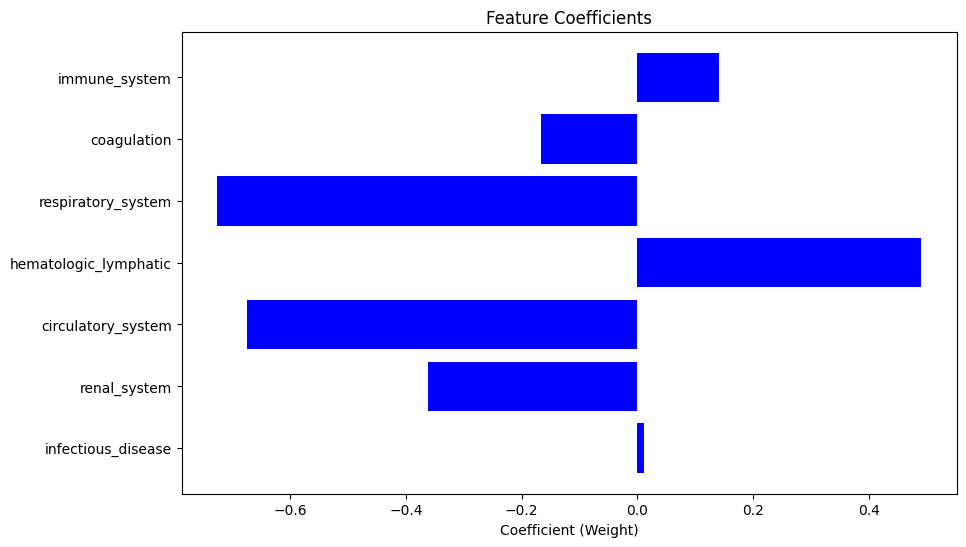

데이터 v1, logistic regression 모델 정확도: 0.7282
ROC-AUC: 0.6516
F1 Score: 0.8362


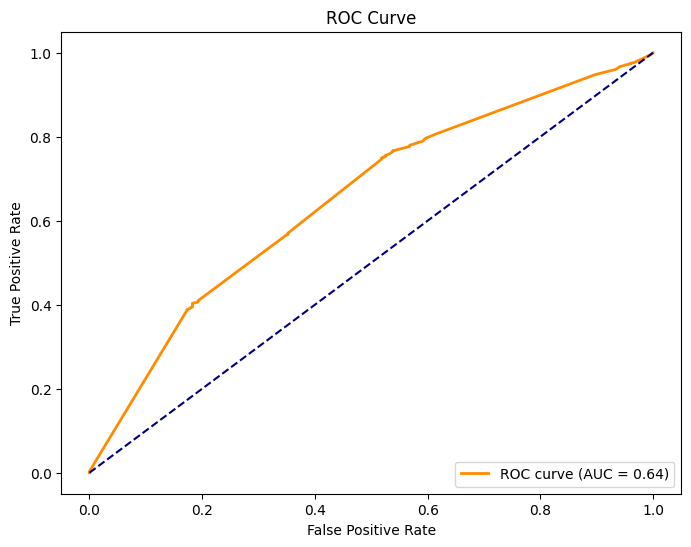

In [15]:
#SMOTE

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
logistic_model.fit(X_train_resampled, y_train_resampled)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v1, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Regression Equation: y = 0.7307 + (-0.0015) * infectious_disease + (-0.4297) * renal_system + (-0.6521) * circulatory_system + (0.1673) * hematologic_lymphatic + (-0.6803) * respiratory_system + (-0.1327) * coagulation + (0.0860) * immune_system
R^2 (Determination Coefficient): -2.5064


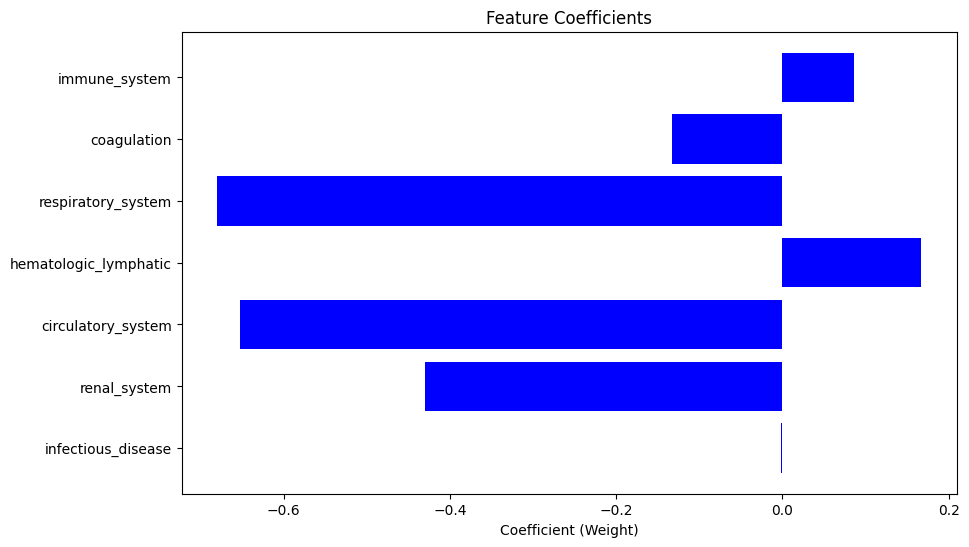

데이터 v1, logistic regression 모델 정확도: 0.7272
ROC-AUC: 0.6494
F1 Score: 0.8355


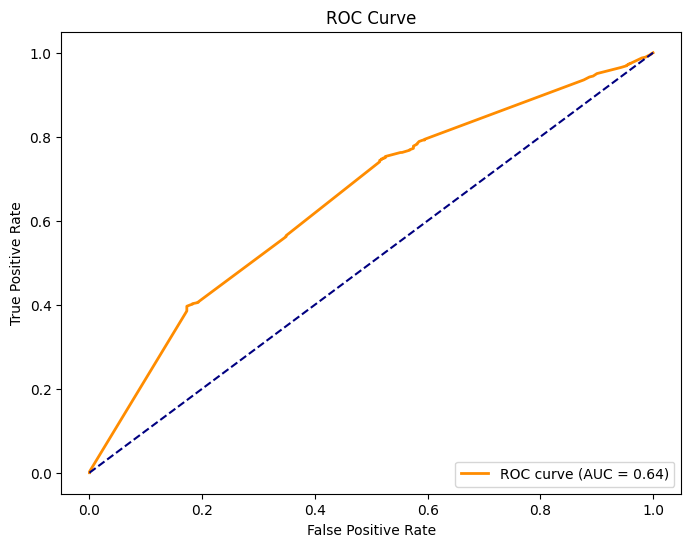

In [16]:
# class_weight='balanced'

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train, y_train)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v1, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Regression Equation: y = 0.7515 + (0.0115) * infectious_disease + (-0.3623) * renal_system + (-0.6746) * circulatory_system + (0.4914) * hematologic_lymphatic + (-0.7265) * respiratory_system + (-0.1655) * coagulation + (0.1408) * immune_system
R^2 (Determination Coefficient): -2.4928


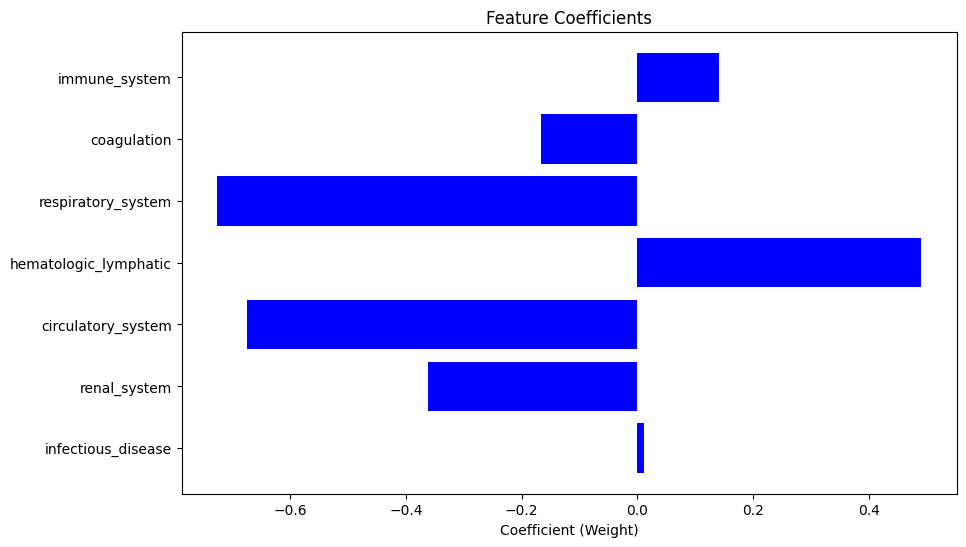

데이터 v1, logistic regression 모델 정확도: 0.7282
ROC-AUC: 0.6516
F1 Score: 0.8362


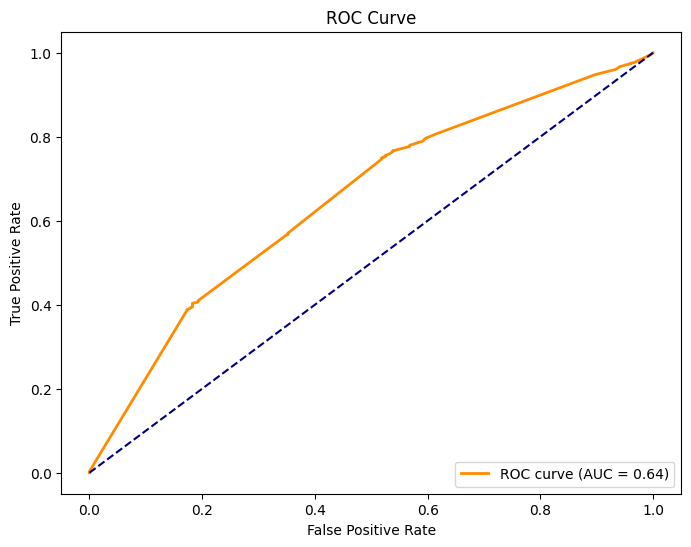

In [17]:
# SMOTE + class_weigjht

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train_resampled, y_train_resampled)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v1, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 

## 랜덤포레스트 모델 적용

### <li>SMOTE 적용 전 -> SMOTE 적용 후
모델 정확도: 0.9288 -> 0.7528
<br> ROC-AUC: 0.6490 -> 0.6447
<br> F1 Score: 0.9631 -> 0.8538


### <li>SMOTE 말고 class_weight='balanced' 적용
모델 정확도: 0.7561
<br> ROC-AUC: 0.6426
<br> F1 Score: 0.8561

### <li>SMOTE 와 class_weight 모두 적용 후
모델 정확도: 0.7528
<br>ROC-AUC: 0.6447
<br>F1 Score: 0.8538


데이터 v1, Random Forest 모델 정확도: 0.7528
ROC-AUC: 0.6447
F1 Score: 0.8538


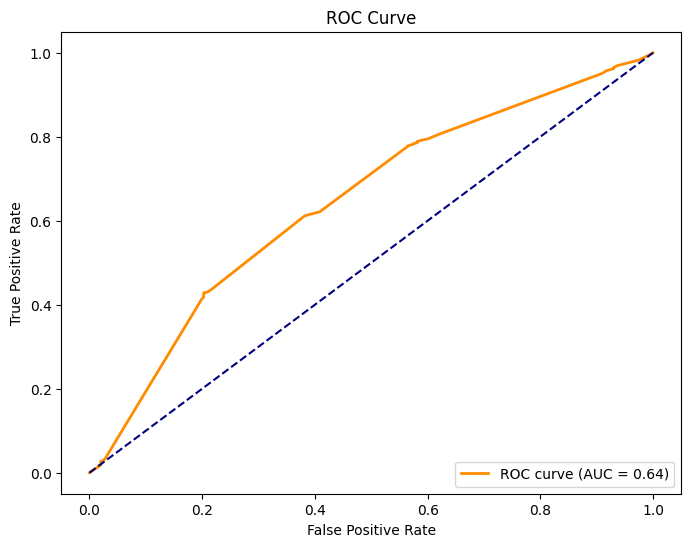

In [18]:
# smote

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v1, Random Forest 모델 정확도: 0.7561
ROC-AUC: 0.6426
F1 Score: 0.8561


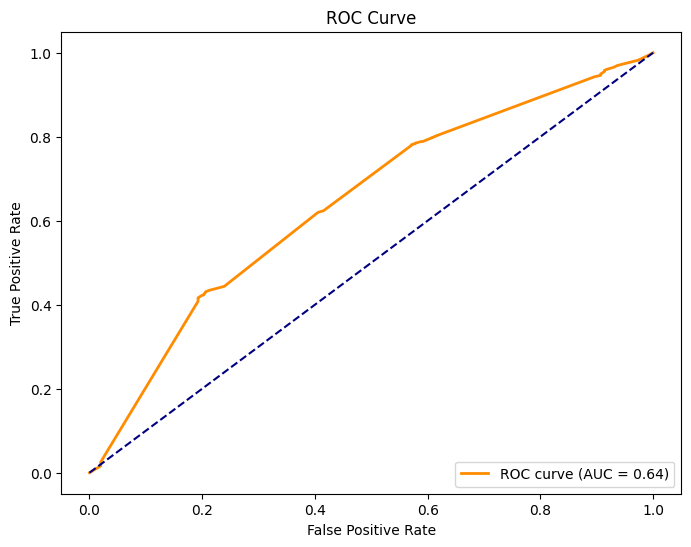

In [22]:
# smote

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v1, Random Forest 모델 정확도: 0.7528
ROC-AUC: 0.6447
F1 Score: 0.8538


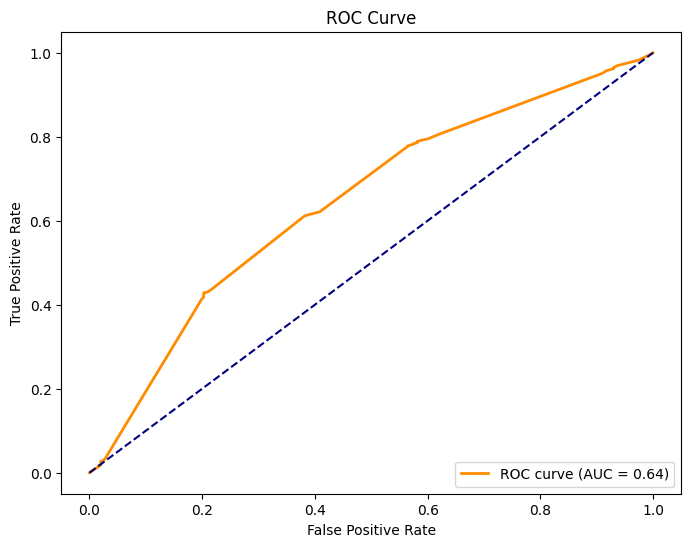

In [13]:
# smote+class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)

# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 

# 

# 

# <질병변수+기본변수 사용>
X는 감염성 질환, 신장계, 순환계, 혈액암/림프종, 호흡기, 혈액응고, 자가면역
<br>Y는 'readmission_within_30_days'

## XGBoost
### <li> SMOTE 사용
모델 정확도: 0.9245 -> 0.8200
<br>ROC-AUC: 0.6693 -> 0.6307
<br>F1 Score: 0.9607 -> 0.8994
    

### <li>scale_pos_weight 사용
모델 정확도: 0.9262
<br>ROC-AUC: 0.6698
<br>F1 Score: 0.9616

### <li>SMOTE 와 scale_pos_weight 모두 적용 후
모델 정확도: 0.8682
<br>ROC-AUC: 0.6254
<br>F1 Score: 0.9287

데이터 v2, XGBoost 모델 정확도: 0.8200
ROC-AUC: 0.6307
F1 Score: 0.8994


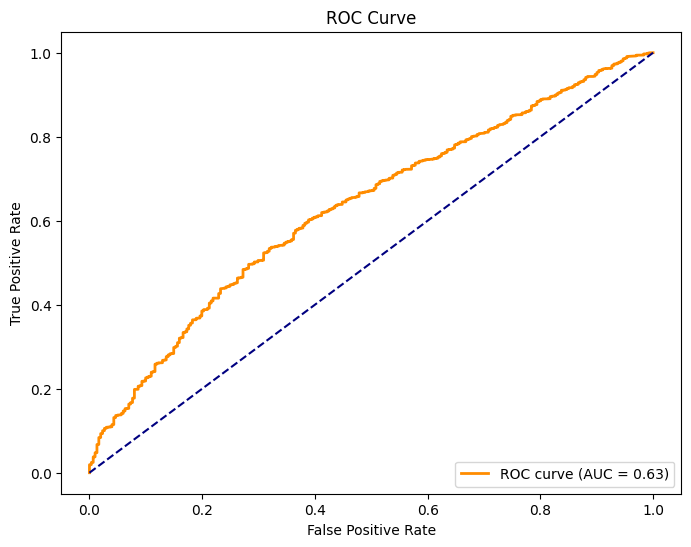

In [10]:
# SMOTE

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

데이터 v2, XGBoost 모델 정확도: 0.9262
ROC-AUC: 0.6698
F1 Score: 0.9616


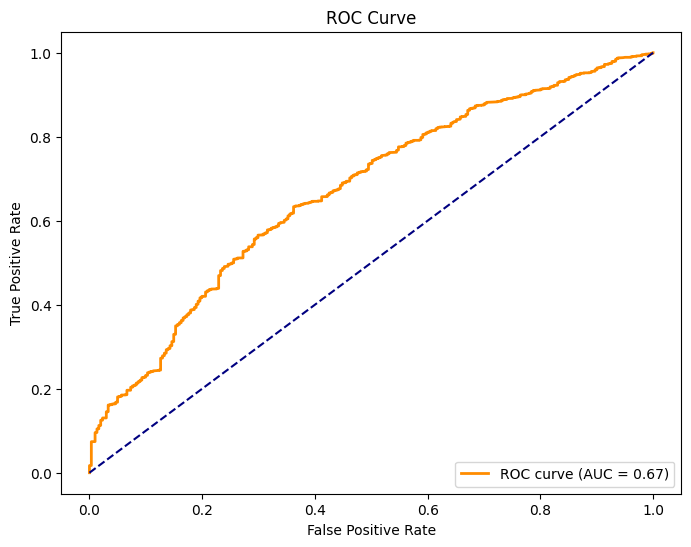

In [19]:
# scale_pos_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale_pos_weight 설정
scale_pos_weight = len(y_train) / sum(y_train)  # Negative to positive class ratio

# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)


# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

데이터 v2, XGBoost 모델 정확도: 0.8682
ROC-AUC: 0.6254
F1 Score: 0.9287


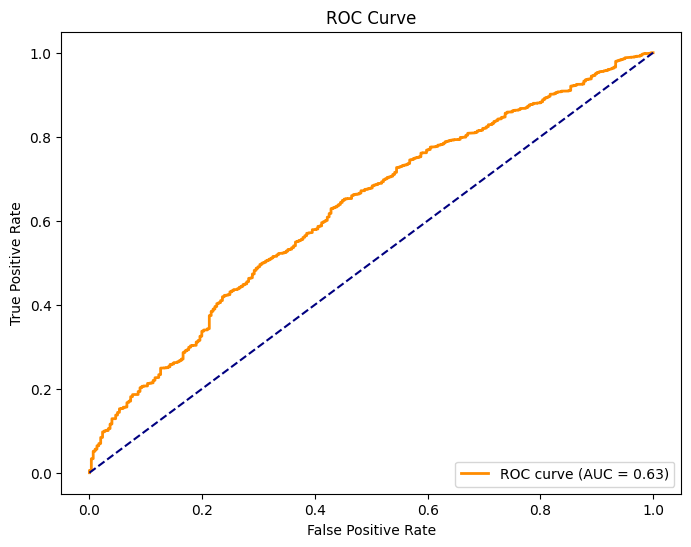

In [20]:
# SMOTE + scale_pos_weight=scale_pos_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scale_pos_weight 설정
scale_pos_weight = len(y_train_resampled) / sum(y_train_resampled)  # Negative to positive class ratio
# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_resampled, y_train_resampled)


# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 

# 로지스틱 회귀모델

### <li>SMOTE 적용 전 -> SMOTE 적용 후
모델 정확도: 0.9288 -> 0.6212
<br> ROC-AUC: 0.7050 -> 0.6158
<br> F1 Score: 0.9631 -> 0.7543


### <li>SMOTE 말고 class_weight='balanced' 적용
모델 정확도: 0.6499
<br> ROC-AUC: 0.7052
<br> F1 Score: 0.7745

### <li>SMOTE 와 class_weight='balanced' 모두 적용    
모델 정확도: 0.6212
<br>ROC-AUC: 0.6158
<br>F1 Score: 0.7543

Regression Equation: y = -2.2995 + (0.1597) * admission_type + (0.5851) * insurance + (0.5755) * gender + (0.0063) * anchor_age + (0.1095) * seq_num + (0.3328) * infectious_disease + (0.7216) * renal_system + (-0.3013) * circulatory_system + (1.5851) * hematologic_lymphatic + (-0.2805) * respiratory_system + (-0.3171) * coagulation + (0.3818) * immune_system
R^2 (Determination Coefficient): -2.4258


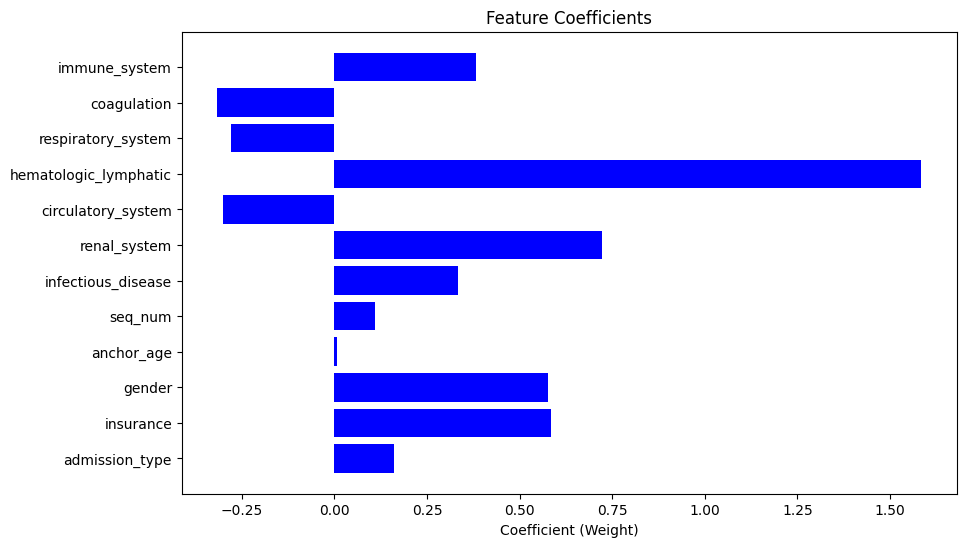

데이터 v2, logistic regression 모델 정확도: 0.6212
ROC-AUC: 0.6158
F1 Score: 0.7543


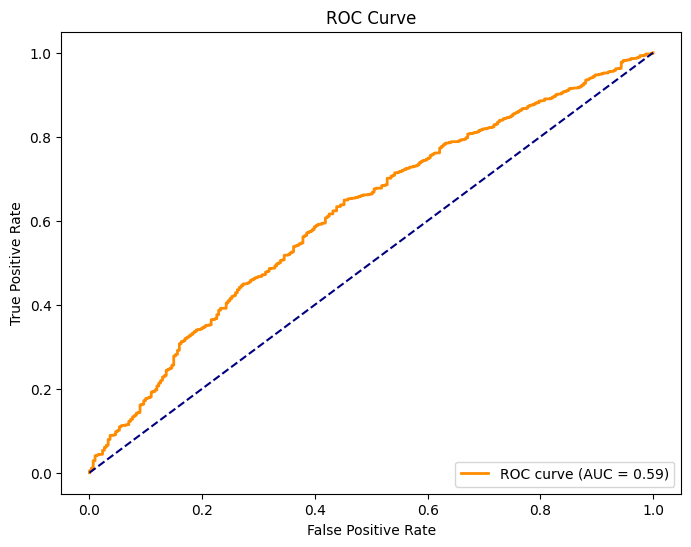

In [14]:
# SMOTE

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
logistic_model.fit(X_train_resampled, y_train_resampled)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v2, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Regression Equation: y = -0.7422 + (0.1163) * admission_type + (0.1683) * insurance + (-0.1233) * gender + (0.0081) * anchor_age + (0.0925) * seq_num + (0.0828) * infectious_disease + (-0.3676) * renal_system + (-0.7113) * circulatory_system + (0.2281) * hematologic_lymphatic + (-0.7134) * respiratory_system + (-0.1460) * coagulation + (0.1365) * immune_system
R^2 (Determination Coefficient): -2.3614


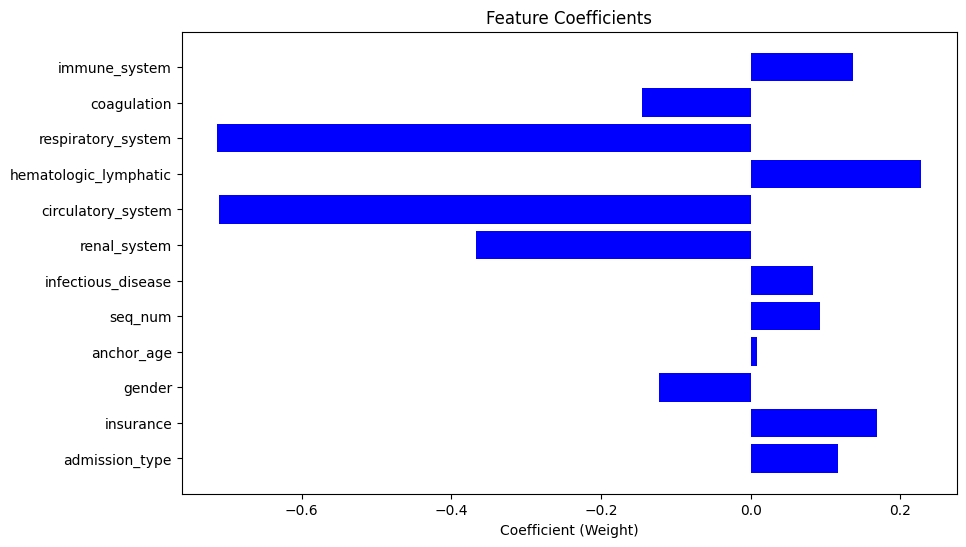

데이터 v2, logistic regression 모델 정확도: 0.6499
ROC-AUC: 0.7052
F1 Score: 0.7745


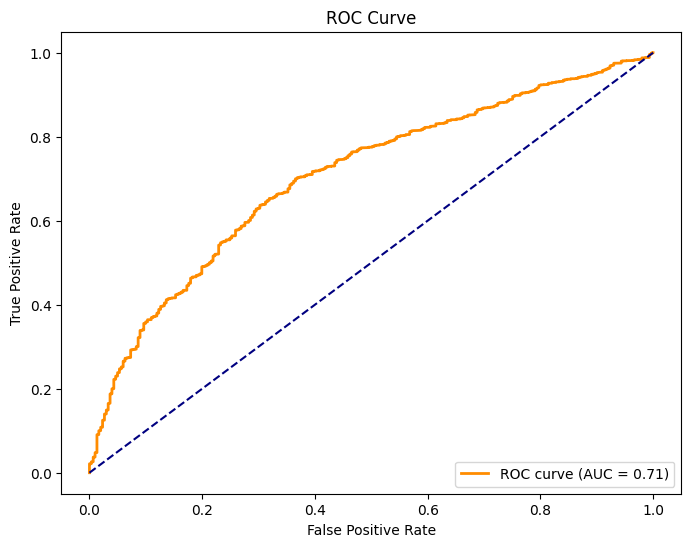

In [6]:
# class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train, y_train)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v2, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_l:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Regression Equation: y = -2.2995 + (0.1597) * admission_type + (0.5851) * insurance + (0.5755) * gender + (0.0063) * anchor_age + (0.1095) * seq_num + (0.3328) * infectious_disease + (0.7216) * renal_system + (-0.3013) * circulatory_system + (1.5851) * hematologic_lymphatic + (-0.2805) * respiratory_system + (-0.3171) * coagulation + (0.3818) * immune_system
R^2 (Determination Coefficient): -2.4258


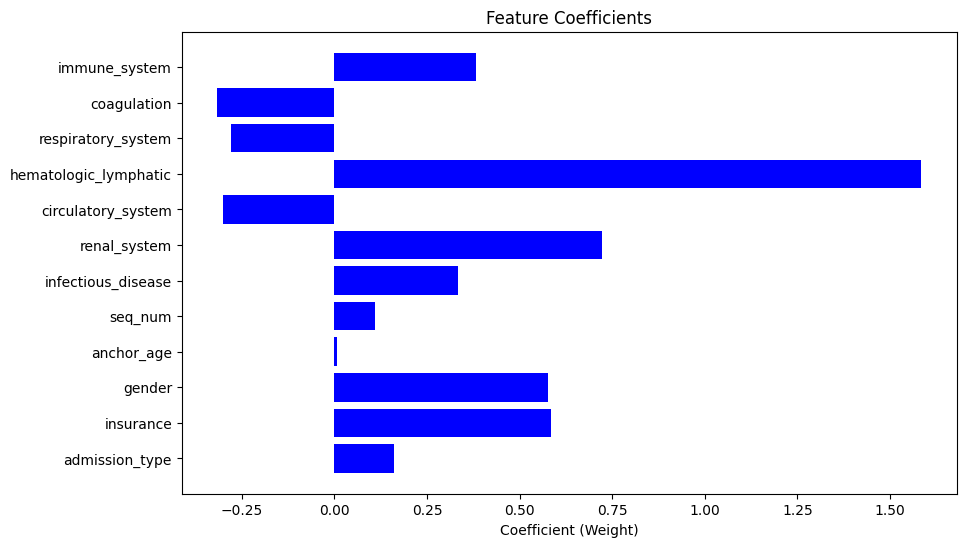

데이터 v2, logistic regression 모델 정확도: 0.6212
ROC-AUC: 0.6158
F1 Score: 0.7543


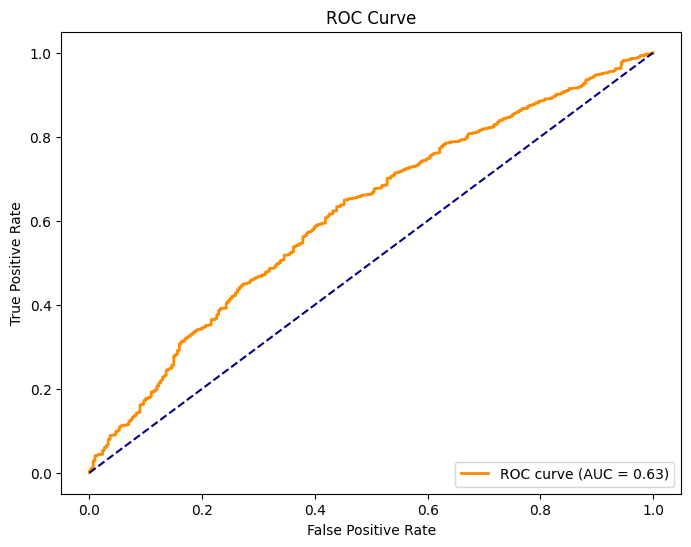

In [23]:
# SMOTE + class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train_resampled, y_train_resampled)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v2, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 

## 랜덤포레스트 모델 수행 결과

### <li>SMOTE 적용 전 -> SMOTE 적용 후
모델 정확도: 0.9042 -> 0.8252
<br>ROC-AUC: 0.6191 -> 0.5901
<br> F1 Score: 0.9494 -> 0.9028


### <li> SMOTE 말고 class_weight 적용 후
모델 정확도: 0.8772
<br>ROC-AUC: 0.6221
<br>F1 Score: 0.9339    
    

### <li>SMOTE 와 class_weight 모두 적용 후
모델 정확도: 0.8252
<br>ROC-AUC: 0.5901
<br>F1 Score: 0.9028   
    

데이터 v2, Random Forest 모델 정확도: 0.8252
ROC-AUC: 0.5901
F1 Score: 0.9028


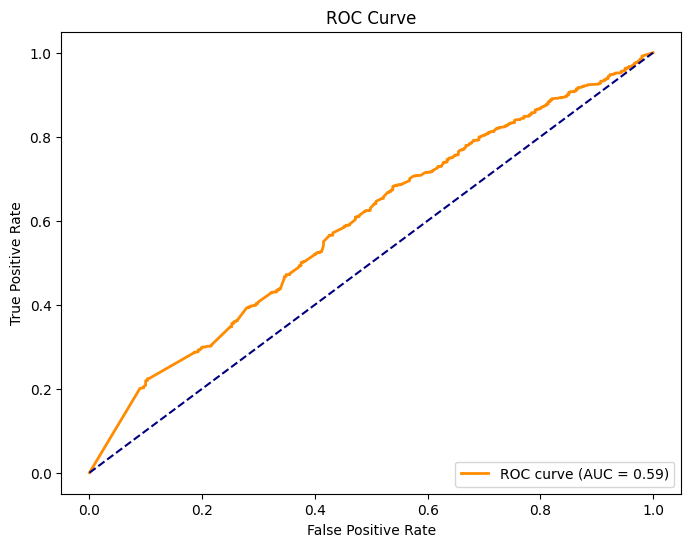

In [28]:
# SMOTE

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)


# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v2, Random Forest 모델 정확도: 0.8772
ROC-AUC: 0.6221
F1 Score: 0.9339


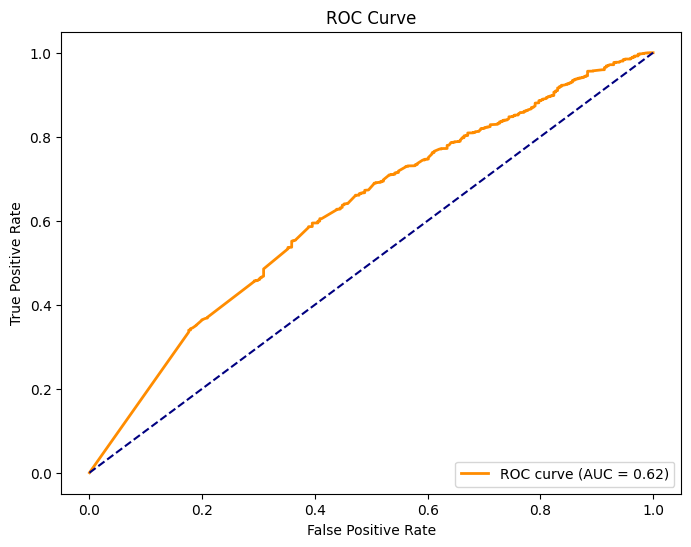

In [27]:
# class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


데이터 v2, Random Forest 모델 정확도: 0.8252
ROC-AUC: 0.5901
F1 Score: 0.9028


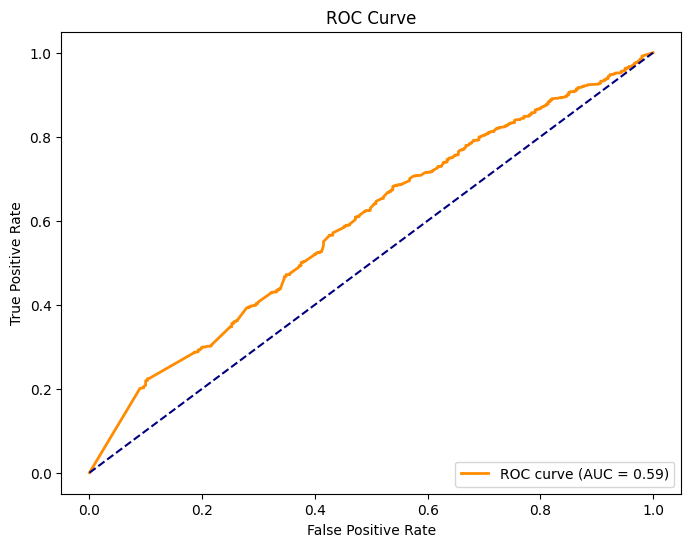

In [26]:
# SMOTE + class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)


# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### 수술 icd_code(9, 10)을 조인할 때 생긴 중복 샘플이 제거되지 않은 데이터에 대한 확인

In [89]:
b_grouped['readmission_within_30_days'].value_counts()

1    12990
0     1099
Name: readmission_within_30_days, dtype: int64

In [8]:
data = pd.read_csv('./data/enteral_data_final.csv')

In [9]:
data

,hadm_id,subject_id,admission_type,insurance,admittime,dischtime,gender,anchor_age,icd_code,seq_num,long_title,time_to_next_admission,readmission_within_30_days,infectious_disease,renal_system,circulatory_system,hematologic_lymphatic,respiratory_system,coagulation,immune_system
0,20001361,14577567,5,0,2143-05-04 14:55:00,2143-05-18 16:58:00,1,30,0,3.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
1,20004357,19657904,5,1,2157-08-05 10:57:00,2157-08-12 18:00:00,0,75,0,4.0,0,0 days 00:00:00,1,0,0,1,0,1,0,0
2,20004775,13158794,5,1,2187-03-07 16:32:00,2187-03-15 15:36:00,0,82,0,1.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
3,20005119,19244907,5,2,2112-11-08 20:25:00,2112-12-16 17:42:00,0,56,0,12.0,0,235 days 19:17:00,0,0,0,1,0,0,0,0
4,20005479,19669999,5,1,2148-06-01 12:48:00,2148-06-07 18:38:00,0,84,0,3.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14084,29997422,15060292,1,2,2155-03-04 15:56:00,2155-03-18 14:23:00,1,32,0,5.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
14085,29998115,19989305,5,2,2154-05-06 03:02:00,2154-05-20 15:40:00,1,23,0,5.0,0,0 days 00:00:00,1,0,0,1,0,0,0,0
14086,29998592,15272445,5,0,2168-05-28 21:57:00,2168-06-09 05:30:00,1,30,0,4.0,0,0 days 00:00:00,1,0,0,1,0,0,0,0
14087,29999444,10053207,5,1,2199-12-14 17:54:00,2199-12-22 14:01:00,0,55,0,1.0,0,-991 days +01:17:00,1,0,0,0,0,0,0,0


In [86]:
print("seq_num 결측치 개수: ", enteral_infusion_data_10['seq_num'].isnull().sum())

seq_num 결측치 개수:  0


In [87]:
enteral_infusion_data_10

,subject_id,hadm_id,admission_type,insurance,admittime,dischtime,gender,anchor_age,icd_code,seq_num,long_title,time_to_next_admission,readmission_within_30_days,infectious_disease,renal_system,circulatory_system,hematologic_lymphatic,respiratory_system,coagulation,immune_system
0,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
1,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
2,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
3,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
4,11785054,26269995,3,2,2115-02-08 17:52:00,2115-03-24 11:30:00,1,0,0,2.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70634347,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
70634348,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
70634349,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0
70634350,16624205,23962991,5,2,2126-02-03 15:27:00,2126-03-18 16:15:00,0,44,0,7.0,0,0 days 00:00:00,1,0,0,0,0,0,0,0


In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 문자열 데이터를 범주형으로 변환
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 제안
    C = trial.suggest_loguniform('C', 1e-4, 1e4)  # 규제 강도
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])  # 클래스 가중치

    # 로지스틱 회귀 모델 생성
    logistic_model = LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        C=C,
        class_weight=class_weight
    )

    # 교차 검증 점수 계산 (F1 스코어 사용)
    f1 = cross_val_score(logistic_model, X_train, y_train, cv=3, scoring='f1').mean()

    return f1  # F1 스코어 최대화 목표

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')  # 최대화 목표
study.optimize(objective, n_trials=50)  # 50번의 반복

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {study.best_params}")
print(f"Best F1 Score: {study.best_value:.4f}")

# 최적의 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
final_model = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    C=best_params['C'],
    class_weight=best_params['class_weight']
)
final_model.fit(X_train, y_train)

# 테스트 데이터에서 평가
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]  # 확률값

# 평가 결과 출력
accuracy = accuracy_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()